# Chemical space and its visualization
In previous exercises, we have obtained skills to work with molecules as objects in Python and calculate various descriptors for them. Now, we will use these "numbers" to visualize [Chemical space](https://en.wikipedia.org/wiki/Chemical_space) of our ligands and drugs. You surely heard about it in lectures. Simply said, when we have numbers, we can project them into some plot. However, 1024 dimensional space of fingerprints is too much to find there anything reasonable. As mind exercise, try to imagine 4D or 5D plot. Nontheless, in this exercise, we will prepare some maps for our compounds. We will use some descriptors, fingerprints and to reduce number of dimensions [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). These tools are pretty popular and you can easily find many articles. And yes, we use them too.

So what will we need to visualize our data? Of course RDKit and something to plot (Seaborn, Matplotlib or whatever you want). Something to work with our number space, I use scikit-learn and with it we will also train model.

In [1]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

## Data preparation

In [2]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [3]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [4]:
# load mtor, we want to remember source of data and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("../data/chembl_mtor_ic50.csv") as inp:
    mtor = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in mtor:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "mtor"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [5]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [6]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *mtor), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

## Common plots
We have loaded data and we can put them to some plot(s). Out of competition, how many combinations of our 6 descriptors do we have and can visualize?

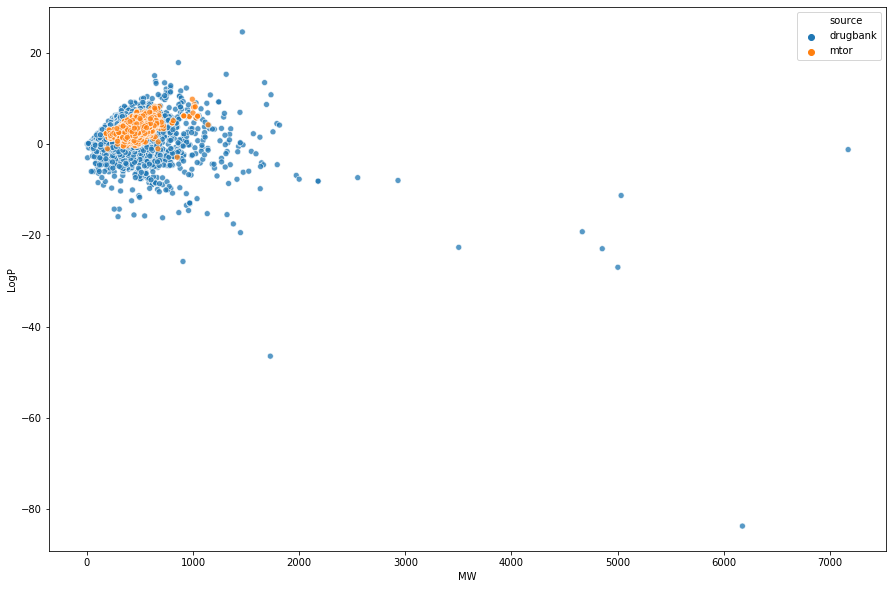

In [7]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

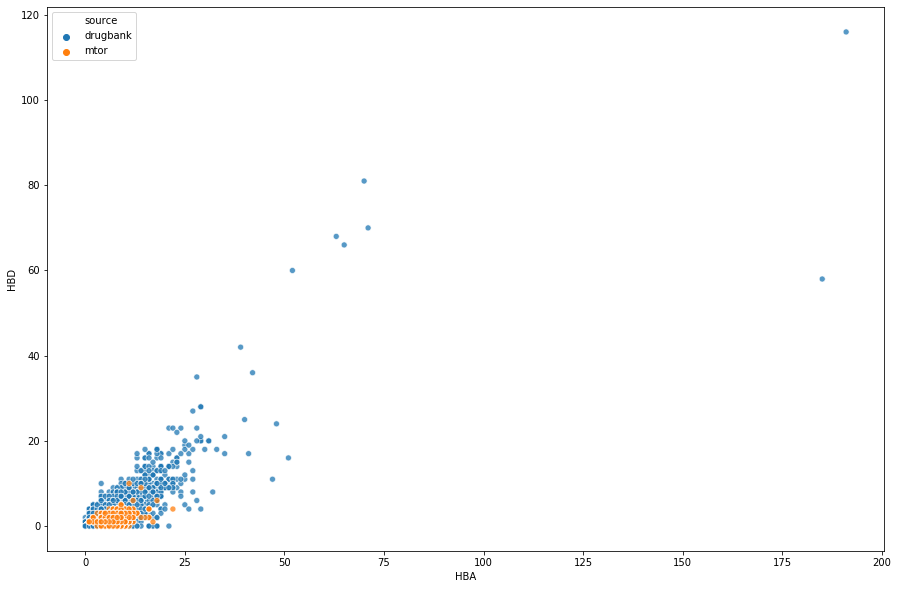

In [8]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

What would you say to use some established slightly bigger descriptor set? For example [MQNs](https://dx.doi.org/10.1021/cn3000422). Aren't you familiar with it. Have you seen the image in the Chemical space page at Wikipedia? It's 42 chemical descriptors like number of carbons, nitrogens, rings, double bonds, donors etc. You can guess what ploted numbers means.

In [9]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

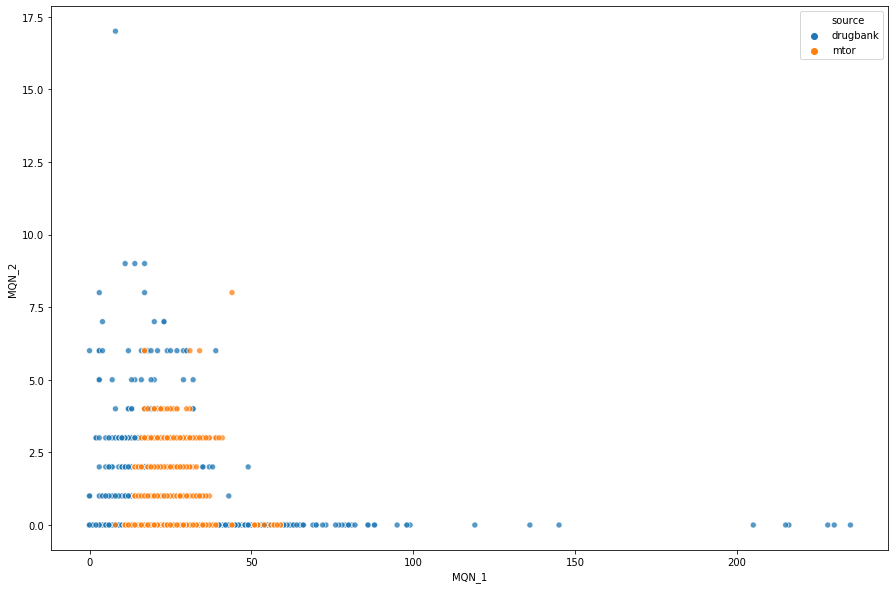

In [10]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## PCA
First method we use to reduce the number of dimensions is PCA. PCA itself only changes coordination system so it would not help us, but it has special ability that components are ordered in the way the first component describes the most variance in data, the others gradually less. Thus, if we take first two components, we get as much information as possible.

In [11]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

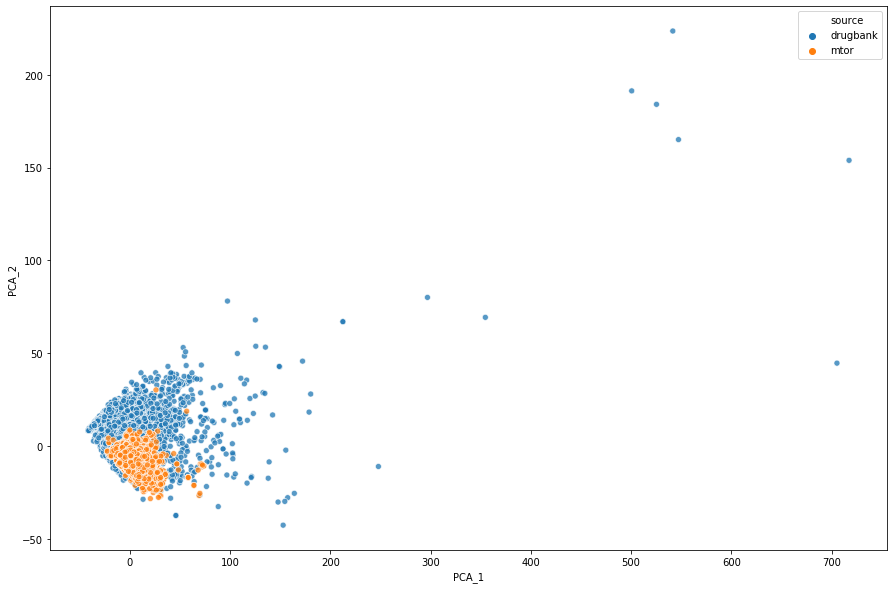

In [12]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

It looks good but ... do you remember the sentence about variance and PCA? When we multiply some variably by 100, its variance will be also multiplied by 100. Thus, you may want to [normalize](https://en.wikipedia.org/wiki/Normalization_(statistics)) (or to do something similar) all variables to make them comparable.

In [13]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

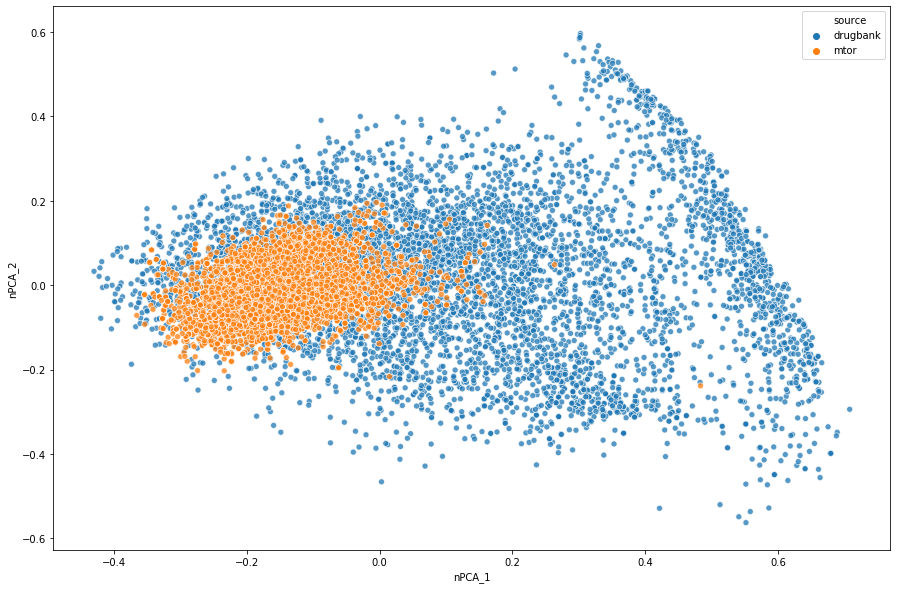

In [14]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## MDS
[Multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) puts instances to lower dimensional space (typically 2D/3D). Method is iterative and tries to keep similar distances between points in the original and new spaces. 

In [15]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [16]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

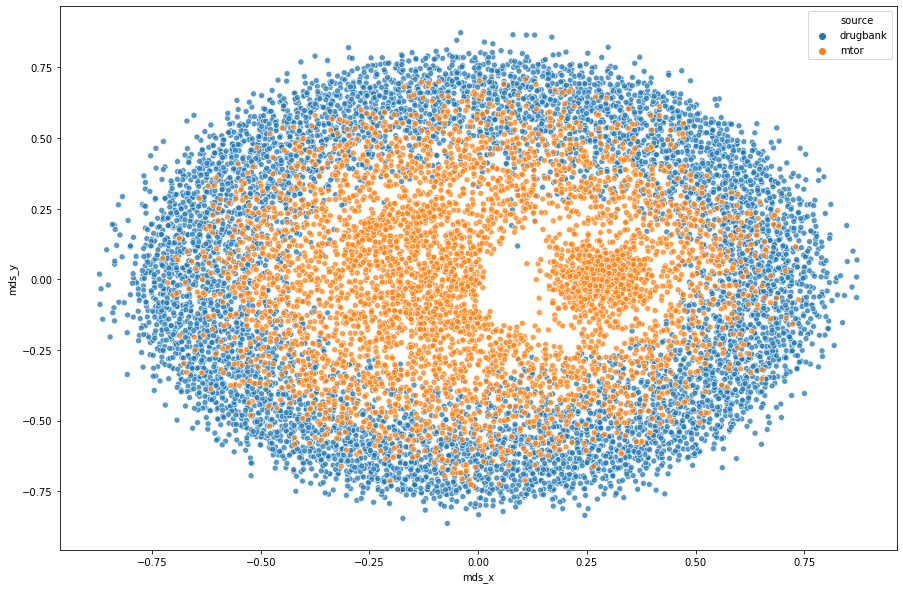

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## t-SNE
[t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is another popular method to show similar instances close together and dissimilar far. We can recycle distances calculated for MDS.

In [18]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

In [19]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

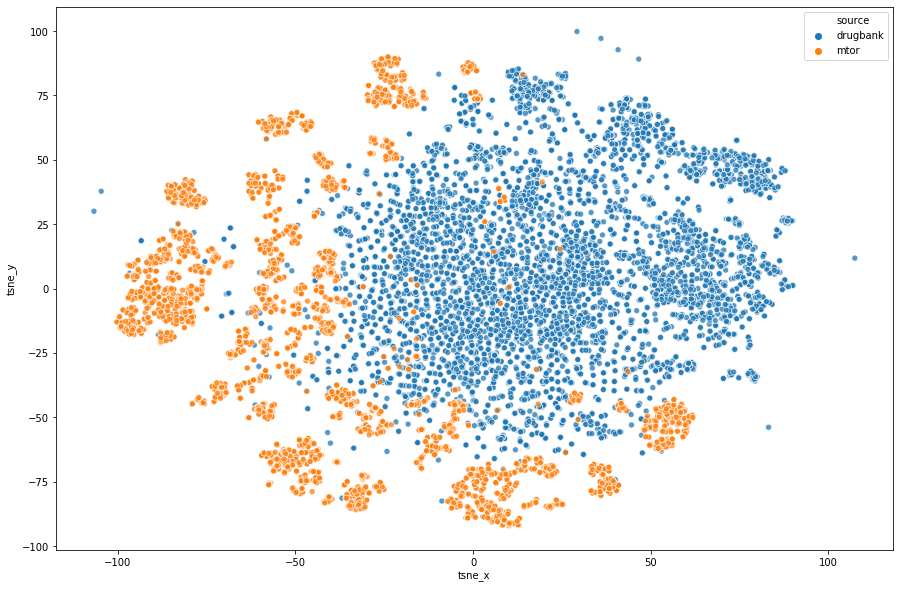

In [20]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## How can we use it?
### Use case 1: Diversity picker

In [21]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [22]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

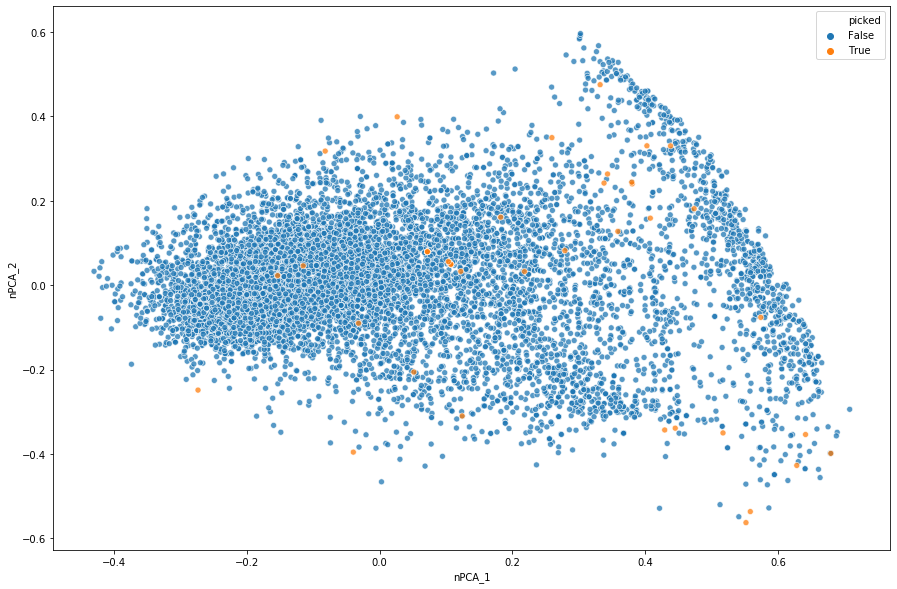

In [23]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

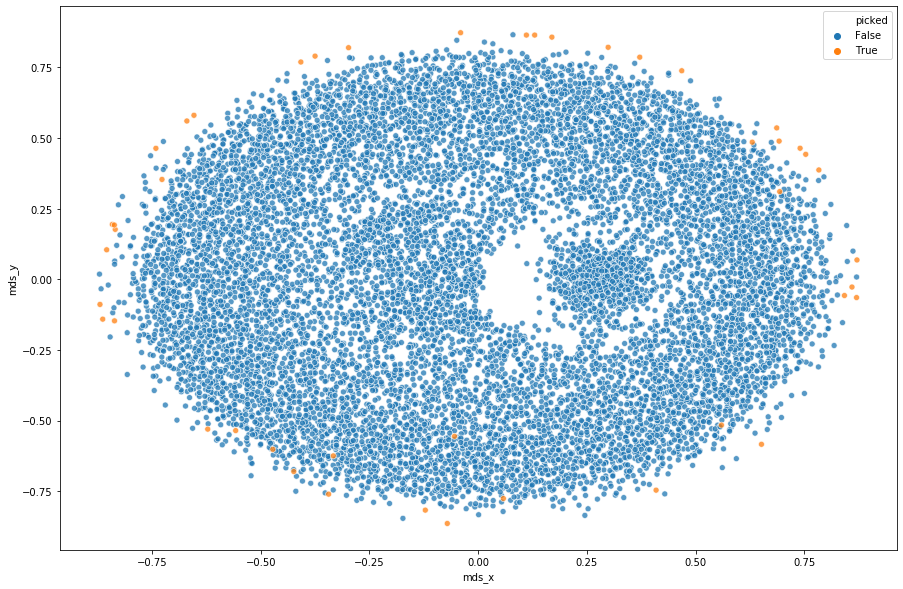

In [24]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

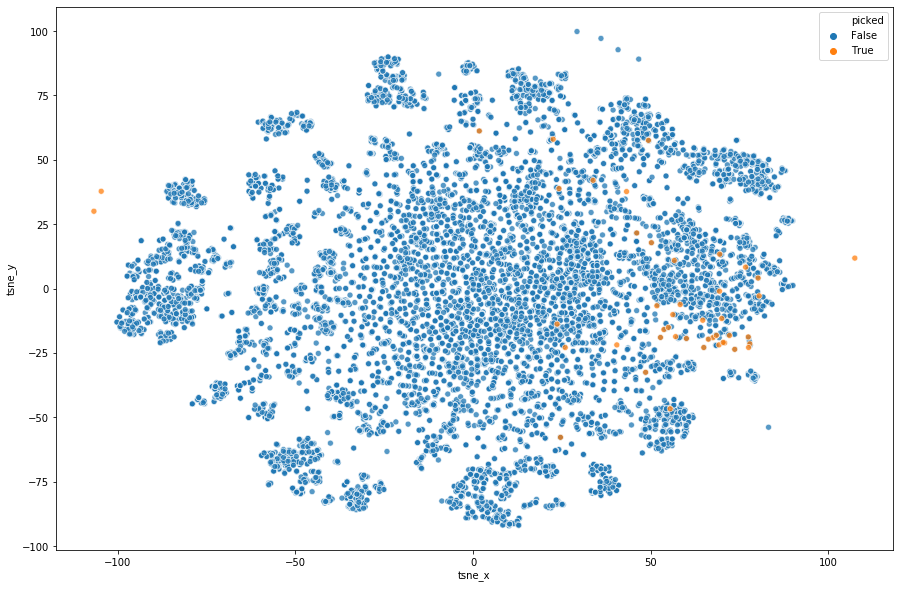

In [25]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

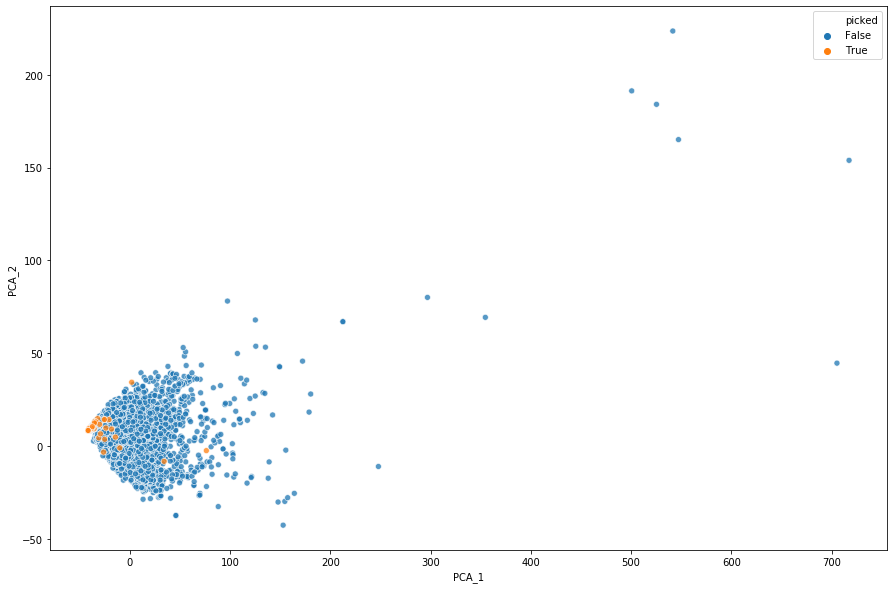

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1",
                      y="PCA_2",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

At least by MDS and slightly by t-SNE, we can see our diversity picking works. Of course, PCA wasn't trained on the fingerprints so we can't say much about it.

### Use case 2: Activities or descriptors

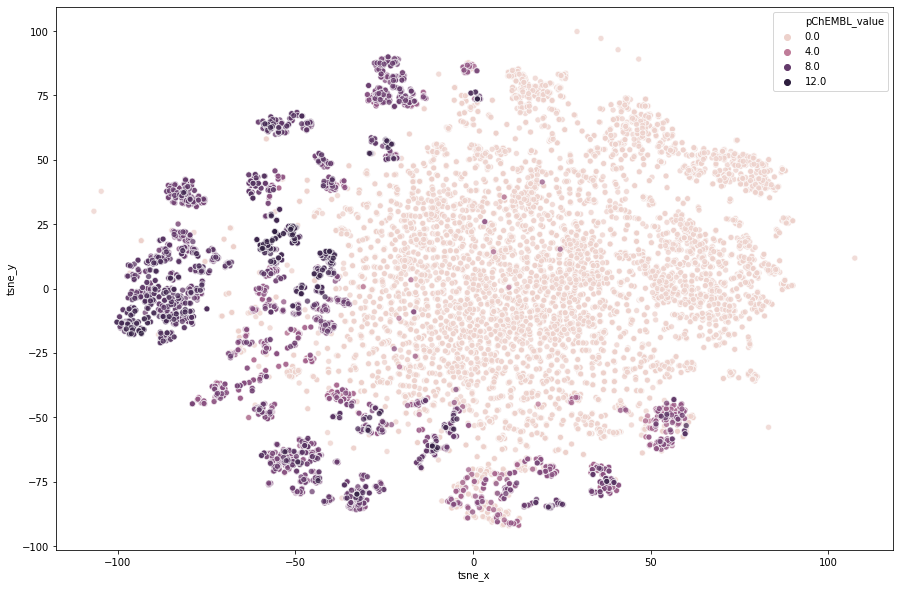

In [27]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

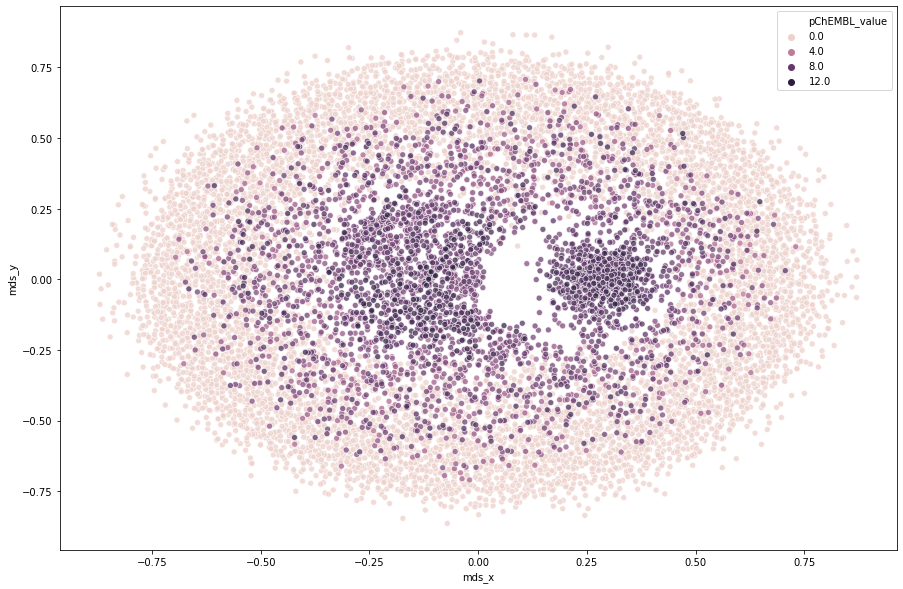

In [28]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

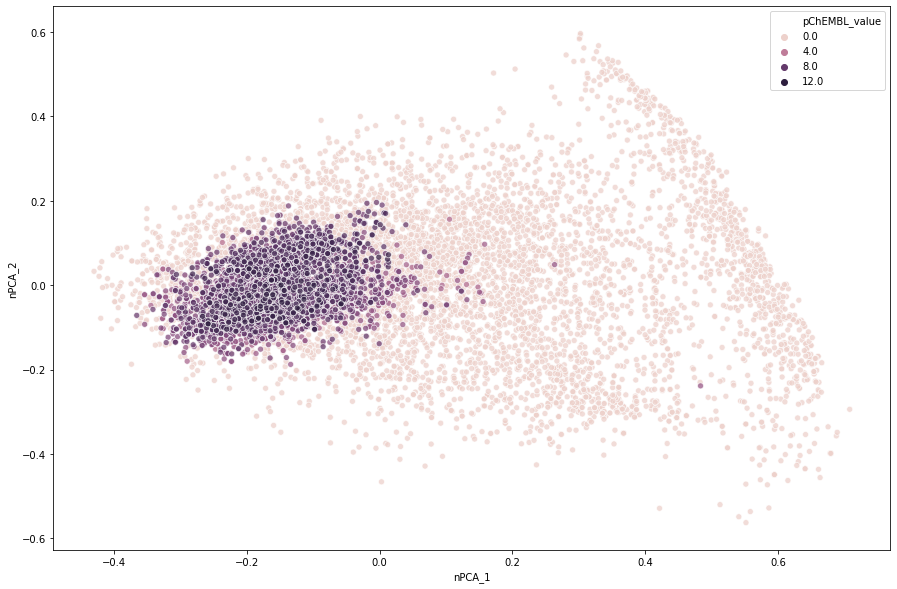

In [29]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Shouldn't we use only mtor for calculation as we don't have real activities for drugbank?

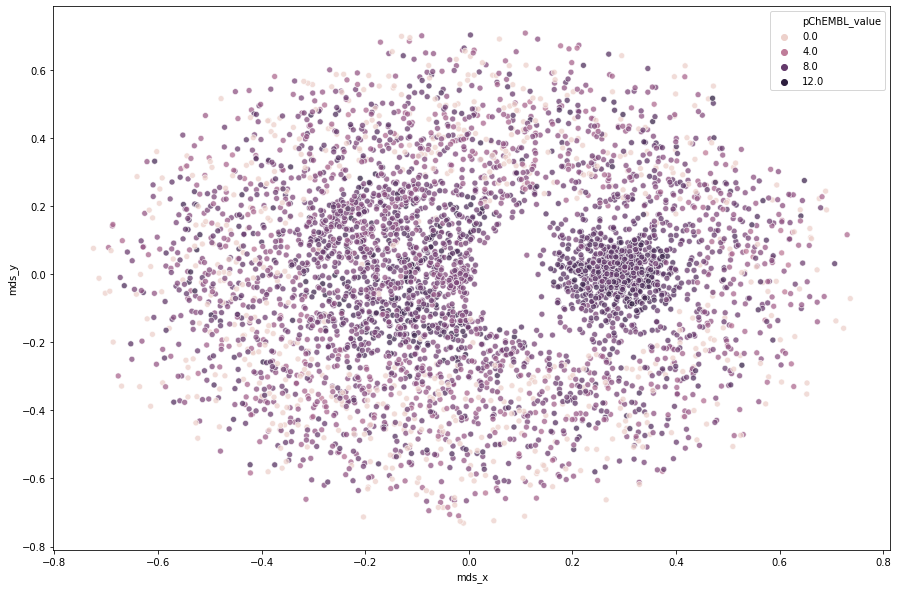

In [30]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df[df.source == "mtor"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

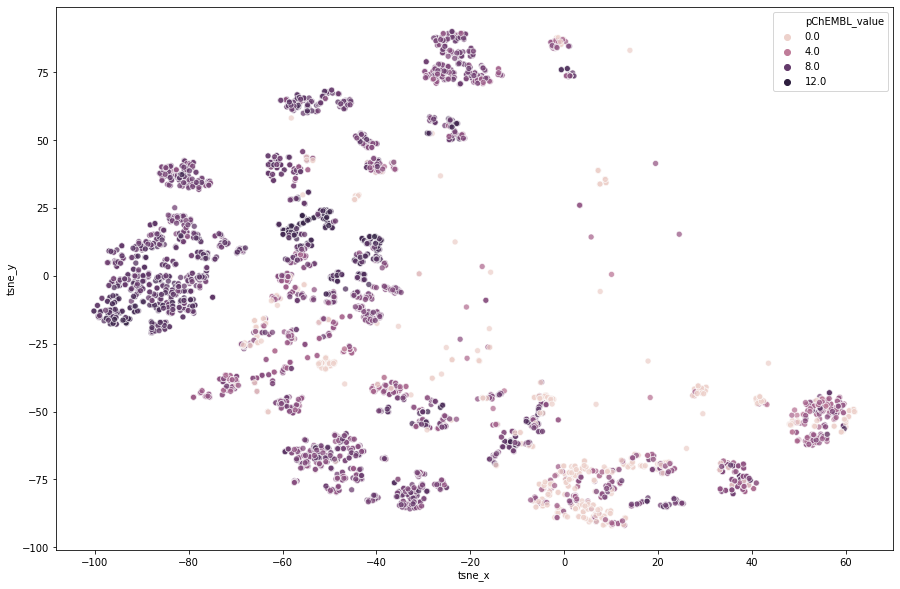

In [31]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df[df.source == "mtor"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

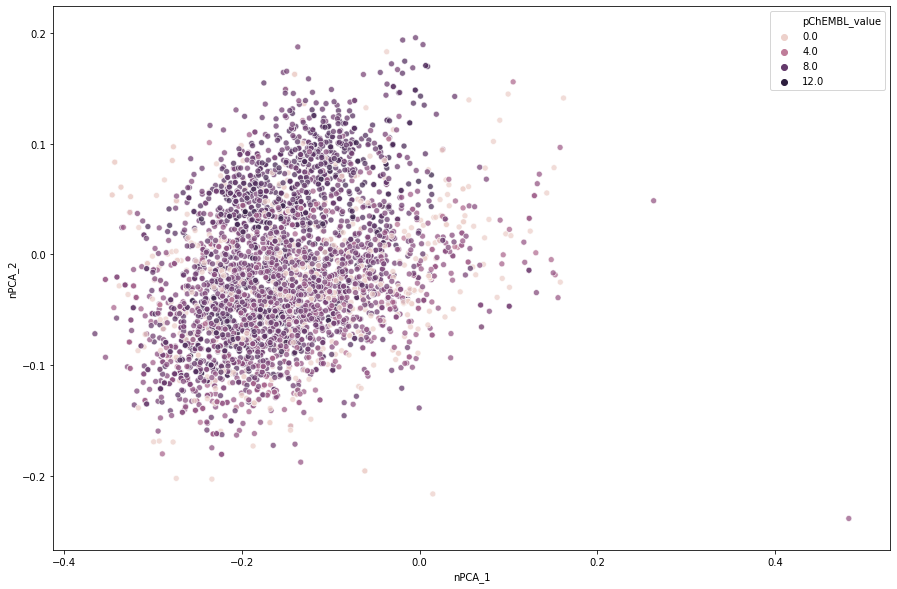

In [32]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "mtor"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## What to do
* Familiarize yourself with visualization methods. If mentioned methods in this exercise are not enough you can surely find more methods in scikit-learn. You can see that the methods work but you should understand what they do, may be you can't use them for your data.
* Try to visualize some features of your compounds such as activity, number of carbons, rings etc.
* Show if your compounds with same scaffold are close on your map(s)